In [ ]:
!pip install transformers

In [ ]:
import torch
import torch.nn as nn
from transformers import BertForTokenClassification, BertTokenizer, AdamW
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("anferico/bert-for-patents")
# Define the number of entity labels
num_labels = 5 # Replace with the actual number of entity labels
input_length = 200

In [ ]:
mapping = [
   {
      "name":"0",
      "id":0
   },
   {
      "name":"Invention",
      "id":1
   },
   {
      "name":"MainComponent",
      "id":2
   },
   {
      "name": "SubComponent",
      "id": 3
   },
   {
      "name": "ApplicationDomain",
      "id": 4
   }
]
def convert_entitiy_label_encode(entitiy_label):
  encoded_labels = [0] * len(entitiy_label)
  for idx, entity in enumerate(entitiy_label):
    for m in mapping:
      if entity == m['name']:
        encoded_labels[idx] = m['id']
  return encoded_labels


In [ ]:
def extract_lables_tokens_to_bert_format(dataset):
    bert_dataset = []
    for idx,example in enumerate(dataset):
      example = json.loads(example)
      tokens = example["tokens"]
      spans = example["spans"]
      tokens = [token['text'] for token in tokens]

      # Tokenize the text
      #tokens = tokenizer.tokenize(text)

      # Initialize entity labels for each token
      entity_labels = ["O"] * input_length

      for span in spans:
        start = span["token_start"]
        end = span["token_end"]
        label = span["label"]

        # Mark the tokens corresponding to the entity with the entity label
        for i in range(start, end + 1):
          entity_labels[i] = label

      # Convert tokens and entity labels to input features
      #input_ids = tokenizer.convert_tokens_to_ids(tokens)
      #attention_mask = [1] * len(input_ids)
      entity_labels_ids = convert_entitiy_label_encode(entity_labels)
      #entity_labels_ids.insert(0,0)
      #entity_labels_ids.append(0)
      #print(entity_labels_ids)

      # Create a dictionary containing the input features
      features = {
          "labels": entity_labels_ids,
          "tokens": tokens
      }

      bert_dataset.append(features)

    return bert_dataset



In [ ]:
import pandas as pd
file_path = '/content/claims_annotated_all.jsonl'

import json

with open('/content/claims_annotated_all.jsonl', 'r') as json_file:
    json_list = list(json_file)


# Example usage
dataset = json_list

# Convert the dataset to BERT format
bert_formatted_dataset = extract_lables_tokens_to_bert_format(dataset)

# Print the first example in the BERT format
print(bert_formatted_dataset[-1])


{'labels': [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 4, 4, 4, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'tokens': ['We', 'claim', ':', ' \n     \n       ', '1', '.', 'A', 'sulfur', 'containing', 'catalyst', 'for', 'the', 'electroreduction', 'of', 'oxygen', 'obtainable', 'by', 'sparging', 'a', 'solution', 'of', 'rhodium', 'salt', 'with', 'hydrogen', 'sulfide', ',', 'recovering', 'and', 'drying', 'the', 'resulting', 'product', ',', 'grinding', 'the', 'resulting', 'product', ',', 'and', 's

In [ ]:
# Convert the dataset to input features
def convert_dataset_to_features(dataset):
    input_ids = []
    attention_masks = []
    labels = []

    for example in dataset:
        tokens = example["tokens"]
        labels_ids = example["labels"]
        #labels_ids.append(0)
        #labels_ids.insert(0,0)

        # Tokenize the text
        #input_ids = tokenizer.convert_tokens_to_ids(tokens)
        inputs = tokenizer.encode_plus(
            text = tokens,
            is_split_into_words = True,
            add_special_tokens=False,
            truncation=True,
            padding="max_length",
            max_length=input_length,
            return_tensors="pt"
        )

        input_ids.append(inputs["input_ids"][0])
        attention_masks.append(inputs["attention_mask"][0])
        labels.append(labels_ids)
    print(f"length of input ids: {len(input_ids[0])}, lenth of labels: {len(labels[0])}")

    input_ids = torch.stack(input_ids, dim=0)
    attention_masks = torch.stack(attention_masks, dim=0)
    labels = torch.tensor(labels)

    return TensorDataset(input_ids, attention_masks, labels)



In [ ]:
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

num_examples = len(bert_formatted_dataset)
num_train_examples = int(num_examples * train_ratio)
num_val_examples = int(num_examples * val_ratio)

train_dataset = bert_formatted_dataset[:num_train_examples]
val_dataset = bert_formatted_dataset[num_train_examples:num_train_examples+num_val_examples]
test_dataset = bert_formatted_dataset[num_train_examples+num_val_examples:]


train_dataset = convert_dataset_to_features(train_dataset)
val_dataset = convert_dataset_to_features(val_dataset)
test_dataset = convert_dataset_to_features(test_dataset)


# Create the train dataloader
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=True)

length of input ids: 200, lenth of labels: 200
length of input ids: 200, lenth of labels: 200
length of input ids: 200, lenth of labels: 200


In [ ]:
# Create the BERT model for token classification with dropout
class BertForTokenClassificationWithDropout(BertForTokenClassification):
    def __init__(self, config, dropout_prob=0.7):
        super().__init__(config)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None,
                inputs_embeds=None, labels=None):
        outputs = super().forward(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids,
                                  position_ids=position_ids, head_mask=head_mask, inputs_embeds=inputs_embeds,
                                  labels=labels)

        outputs.logits = self.dropout(outputs.logits)  # Apply dropout

        return outputs

In [ ]:
# Calculate class weights for class-weighted loss
def calculate_class_weights(labels):
  class_weights = compute_class_weight('balanced', classes=np.arange(num_labels),y =np.array(labels))
  return torch.tensor(class_weights, dtype=torch.float32)

# Calculate class weights for the training dataset
train_labels = torch.cat([example[2] for example in train_dataset], dim = 0)
class_weights = calculate_class_weights(train_labels)

In [ ]:
# Create the BERT model for token classification
model = BertForTokenClassificationWithDropout.from_pretrained("anferico/bert-for-patents", num_labels=num_labels)
#model = BertForTokenClassification.from_pretrained("anferico/bert-for-patents", num_labels=num_labels)

# Define the loss function
#loss_fn = nn.CrossEntropyLoss()

# Define the loss function with class weights
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# Define the optimizer
weight_decay = 0.1  # Set the L2 regularization strength
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=weight_decay)
#optimizer = AdamW(model.parameters(), lr=1e-5)

Some weights of BertForTokenClassificationWithDropout were not initialized from the model checkpoint at anferico/bert-for-patents and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 250  # Replace with the desired number of training epochs

# Early stopping parameters
patience = 5
best_val_loss = float('inf')
no_improvement_counter = 0

# Lists to store epoch and loss values
epoch_list = []
train_loss_list = []
val_loss_list = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    for batch in train_dataloader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

    average_train_loss = total_train_loss / len(train_dataloader)

    # Validation
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()

    average_val_loss = total_val_loss / len(val_dataloader)

    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {average_train_loss:.4f} - Validation Loss: {average_val_loss:.4f}")

    epoch_list.append(epoch + 1)
    train_loss_list.append(average_train_loss)
    val_loss_list.append(average_val_loss)

    # Check for early stopping
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss + 0.001
        no_improvement_counter = 0
    else:
        no_improvement_counter += 1

    if no_improvement_counter >= patience:
        print("Early stopping! Validation loss has not improved for", patience, "epochs.")
        break


Epoch 1/250 - Training Loss: 0.3653 - Validation Loss: 0.2107
Epoch 2/250 - Training Loss: 0.2335 - Validation Loss: 0.1945
Epoch 3/250 - Training Loss: 0.2028 - Validation Loss: 0.1843
Epoch 4/250 - Training Loss: 0.1849 - Validation Loss: 0.1874
Epoch 5/250 - Training Loss: 0.1695 - Validation Loss: 0.1758
Epoch 6/250 - Training Loss: 0.1569 - Validation Loss: 0.1756
Epoch 7/250 - Training Loss: 0.1465 - Validation Loss: 0.1749
Epoch 8/250 - Training Loss: 0.1374 - Validation Loss: 0.1836
Epoch 9/250 - Training Loss: 0.1288 - Validation Loss: 0.1741
Epoch 10/250 - Training Loss: 0.1211 - Validation Loss: 0.1883
Epoch 11/250 - Training Loss: 0.1138 - Validation Loss: 0.1833
Epoch 12/250 - Training Loss: 0.1053 - Validation Loss: 0.1854
Epoch 13/250 - Training Loss: 0.0988 - Validation Loss: 0.1795
Epoch 14/250 - Training Loss: 0.0921 - Validation Loss: 0.1930
Early stopping! Validation loss has not improved for 5 epochs.


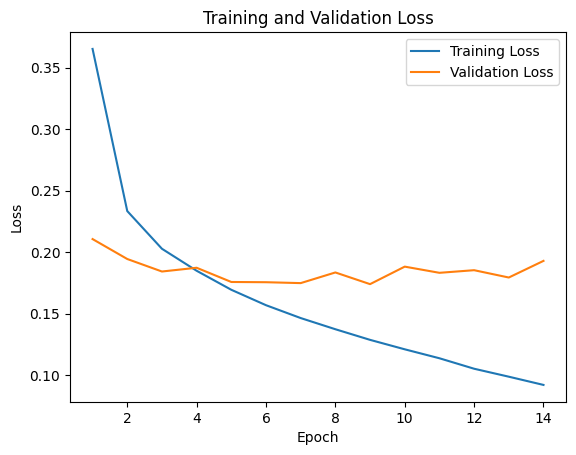

In [ ]:
import matplotlib.pyplot as plt
# Plotting epoch vs. loss
plt.plot(epoch_list, train_loss_list, label='Training Loss')
plt.plot(epoch_list, val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


# Function to evaluate the model on the test set
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predicted_labels = torch.argmax(logits, dim=2)

            # Flatten and remove padding tokens
            predicted_labels_flat = predicted_labels.view(-1)[attention_mask.view(-1) == 1]
            labels_flat = labels.view(-1)[attention_mask.view(-1) == 1]

            all_preds.extend(predicted_labels_flat.tolist())
            all_labels.extend(labels_flat.tolist())

    return all_preds, all_labels

# Evaluate the model on the test set
predicted_labels_train, true_labels_train = evaluate_model(model, train_dataloader)
predicted_labels_test, true_labels_test = evaluate_model(model, test_dataloader)
predicted_labels_validation, true_labels_validation = evaluate_model(model, val_dataloader)

# Calculate accuracy, precision, and recall
accuracy_train = accuracy_score(true_labels_train, predicted_labels_train)
precision_train, recall_train, fscore_train, _ = precision_recall_fscore_support(true_labels_train, predicted_labels_train, average='weighted')
accuracy_test = accuracy_score(true_labels_test, predicted_labels_test)
precision_test, recall_test, fscore_test, _ = precision_recall_fscore_support(true_labels_test, predicted_labels_test, average='weighted')
accuracy_val = accuracy_score(true_labels_validation, predicted_labels_validation)
precision_val, recall_val, fscore_val, _ = precision_recall_fscore_support(true_labels_validation, predicted_labels_validation, average='weighted')

print(f"Training Accuracy: {accuracy_train:.4f}")
print(f"Training Precision: {precision_train:.4f}")
print(f"Training Recall: {recall_train:.4f}")
print(f"Training F1 Score: {fscore_train:.4f}")
print(f"Testing Accuracy: {accuracy_test:.4f}")
print(f"Testing Precision: {precision_test:.4f}")
print(f"Testing Recall: {recall_test:.4f}")
print(f"Testing F1 Score: {fscore_test:.4f}")
print(f"Validation Accuracy: {accuracy_val:.4f}")
print(f"Validation Precision: {precision_val:.4f}")
print(f"Validation Recall: {recall_val:.4f}")
print(f"Validation F1 Score: {fscore_val:.4f}")


Training Accuracy: 0.9141
Training Precision: 0.9149
Training Recall: 0.9141
Training F1 Score: 0.9144
Testing Accuracy: 0.7986
Testing Precision: 0.7963
Testing Recall: 0.7986
Testing F1 Score: 0.7974
Validation Accuracy: 0.8142
Validation Precision: 0.8100
Validation Recall: 0.8142
Validation F1 Score: 0.8118


In [ ]:
id_to_name_mapping = {label["id"]: label["name"] for label in mapping}

In [ ]:
import torch
import torch.nn.functional as F

# ... (Assuming you have already defined and trained your model and have the test_dataloader) ...

# Function to evaluate the model on the test set
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predicted_labels = torch.argmax(logits, dim=2)

            # Flatten and remove padding tokens
            predicted_labels_flat = predicted_labels.view(-1)[attention_mask.view(-1) == 1]
            labels_flat = labels.view(-1)[attention_mask.view(-1) == 1]

            all_preds.extend(predicted_labels_flat.tolist())
            all_labels.extend(labels_flat.tolist())

    return all_preds, all_labels

# Evaluate the model on the test set
predicted_labels, true_labels = evaluate_model(model, test_dataloader)

# Calculate accuracy for each label
label_accuracy = [0] * num_labels
label_counts = [0] * num_labels

for predicted_label, true_label in zip(predicted_labels, true_labels):
    label_counts[true_label] += 1
    if predicted_label == true_label:
        label_accuracy[true_label] += 1

label_accuracy_percentage = [acc / count * 100 if count > 0 else 0 for acc, count in zip(label_accuracy, label_counts)]
label_precision, label_recall, label_f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, labels=list(id_to_name_mapping.keys()), average=None)

# Print accuracy for each label
for label_id, accuracy_percentage in enumerate(label_accuracy_percentage):
    label_name = model.config.id2label[label_id]
    label_precision_percentage = label_precision[label_id] * 100
    label_recall_percentage = label_recall[label_id] * 100
    label_f1_percentage = label_f1[label_id] * 100
    print(f"Label '{id_to_name_mapping[label_id]}':")
    print(f"  Precision: {label_precision_percentage:.2f}%")
    print(f"  Recall: {label_recall_percentage:.2f}%")
    print(f"  F1-score: {label_f1_percentage:.2f}%")
    print(f"  Accuracy : {accuracy_percentage:.2f}%")


Label '0':
  Precision: 87.16%
  Recall: 87.95%
  F1-score: 87.56%
  Accuracy : 87.95%
Label 'Invention':
  Precision: 87.07%
  Recall: 87.45%
  F1-score: 87.26%
  Accuracy : 87.45%
Label 'MainComponent':
  Precision: 57.59%
  Recall: 55.85%
  F1-score: 56.70%
  Accuracy : 55.85%
Label 'SubComponent':
  Precision: 51.02%
  Recall: 49.08%
  F1-score: 50.03%
  Accuracy : 49.08%
Label 'ApplicationDomain':
  Precision: 52.61%
  Recall: 54.26%
  F1-score: 53.42%
  Accuracy : 54.26%


In [ ]:
print(class_weights)

tensor([ 0.2230, 10.2193,  4.9291,  5.2553, 40.9160])


In [ ]:
# from google.colab import drive

# # # Mount Google Drive
# drive.mount('/content/drive',force_remount=True)

# # Save the trained model to Google Drive
output_dir = "/content/saved_model/"
model.save_pretrained(output_dir)
# tokenizer.save_pretrained(output_dir)